In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
#%matplotlib ipympl
import glob as gb
import csv

In [3]:
res = 28

In [61]:
total = []
t_l = []
#im_data = np.array([])
img_path = gb.glob("data\\*.JPG") 
i = 0
for path in img_path:
    pl = path.lower()
    if "dripping" in pl:
        label = 0
    elif "jetting" in pl:
        label = 1
    elif "wetting" in pl:
        label = 2
    else: 
        label = 3
        
    img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE)#'data/Resized_256_256xBroken_0.JPG', cv2.IMREAD_GRAYSCALE)
    if img1 is None:                   #判断读入的img1是否为空，为空就继续下一轮循环
                continue
    res1= cv2.resize(img1,(res,res))              #对图片进行缩放，第一个参数是读入的图片，第二个是制定的缩放大小
    res1 = cv2.equalizeHist(res1)
    res1_1 = res1.flatten()/255.0 #res1_1 = res1.reshape(1,784)/255.0       #将表示图片的二维矩阵转换成一维
    #im_data = np.concatenate((im_data, res1_1))
    res1_1_1 = res1_1.tolist()                     #将numpy.narray类型的矩阵转换成list
    total.append(res1_1_1)  
    t_l.append(label)


# Save Image Data

In [62]:
im_data = np.array(total)
im_data.tofile('data/img'+str(res)+'.bin')
im_lb = np.array(t_l)
im_lb.tofile('data/label'+str(res)+'.bin')

# Load Image Data

In [3]:
res2 = res*res
data = np.fromfile('data/img'+str(res)+'.bin',  dtype=np.float64)
im_data = data.reshape(-1, res2)
im_lb = np.fromfile('data/label'+str(res)+'.bin', dtype=np.int32)

# 2D PCA

In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(im_data)

# 2D PCA Viz

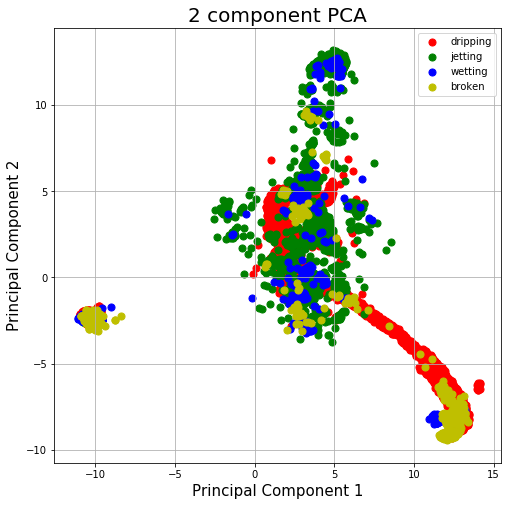

In [68]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2,3]
states = ['dripping', 'jetting', 'wetting', 'broken']
colors = ['r', 'g', 'b', 'y']
for target, color, state in zip(targets,colors,states):
    ##indicesToKeep = finalDf['target'] == target
    ind = im_lb == target
    ax.scatter(principalComponents[ind,0],#finalDf.loc[indicesToKeep, 'principal component 1']
               principalComponents[ind,1],#, finalDf.loc[indicesToKeep, 'principal component 2']
               c = color,
               s = 50)
ax.legend(states)
ax.grid()

# Show one Sample Image

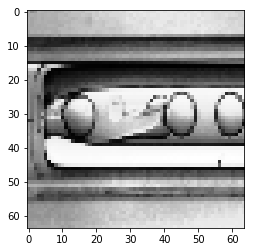

In [66]:
plt.imshow(im_data[0].reshape(res,res),cmap='Greys_r')

# 3D PCA

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(im_data)

# 3D PCA Viz

In [ ]:
#%matplotlib ipympl  # Interactive Mode, Delay due to data size
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_zlabel('PC 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [0,1,2,3]
states = ['dripping', 'jetting', 'wetting', 'broken']
colors = ['r', 'g', 'b', 'y']
for target, color, state in zip(targets,colors,states):
    ##indicesToKeep = finalDf['target'] == target
    ind = im_lb == target
    ax.scatter(principalComponents[ind,0],#finalDf.loc[indicesToKeep, 'principal component 1']
               principalComponents[ind,1],#, finalDf.loc[indicesToKeep, 'principal component 2']
               principalComponents[ind,2],
               c = color,
               s = 50)
ax.legend(states)
ax.grid()

# K Means on Flattened Daata

n_digits: 4, 	 n_samples 40346, 	 n_features 784
__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	18.10s	847213	0.391	0.274	0.322	0.185	0.274	0.428
random   	21.74s	847213	0.391	0.274	0.322	0.185	0.274	0.438
PCA-based	1.81s	847213	0.391	0.274	0.322	0.185	0.274	0.437
__________________________________________________________________________________


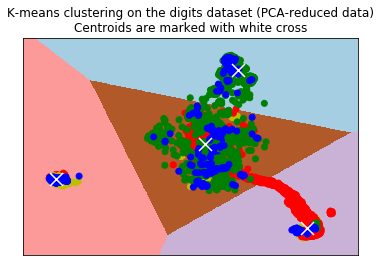

In [14]:

from sklearn.decomposition import PCA
from time import time

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale


n_samples, n_features = im_data.shape
n_digits = len(np.unique(im_lb))
labels = im_lb

sample_size = 300

colors = ['r', 'g', 'b', 'y']
cb = [colors[i] for i in labels]

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(82 * '_')
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=im_data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
               name="random", data=im_data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(im_data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=im_data)
print(82 * '_')

# #############################################################################
# Visualize the results on PCA-reduced data

reduced_data = PCA(n_components=2).fit_transform(im_data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

#plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = cb)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

# PCA in Fourier Domain

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

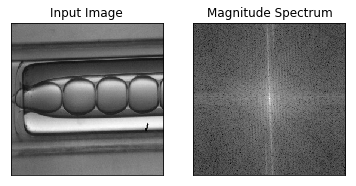

In [16]:
img = cv2.imread('data/Resized_256_256xBroken_10.JPG',cv2.IMREAD_GRAYSCALE)
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

In [4]:
totalf = []
t_lf = []
#im_data = np.array([])
img_path = gb.glob("data\\*.JPG") 
i = 0
for path in img_path:
    pl = path.lower()
    if "dripping" in pl:
        label = 0
    elif "jetting" in pl:
        label = 1
    elif "wetting" in pl:
        label = 2
    else: 
        label = 3
        
    img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE)#'data/Resized_256_256xBroken_0.JPG', cv2.IMREAD_GRAYSCALE)
    if img1 is None:                   #判断读入的img1是否为空，为空就继续下一轮循环
                continue
    res1= cv2.resize(img1,(res,res))              #对图片进行缩放，第一个参数是读入的图片，第二个是制定的缩放大小
    res1 = cv2.equalizeHist(res1)
    #res1_1 = res1.flatten()/255.0 #res1_1 = res1.reshape(1,784)/255.0       #将表示图片的二维矩阵转换成一维
    #im_data = np.concatenate((im_data, res1_1))
    f = np.fft.fft2(res1)
    fshift = np.fft.fftshift(f)
    res1_1 = 20*np.ma.log(np.abs(fshift))
    res1_1_1 = res1_1.flatten().tolist()                     #将numpy.narray类型的矩阵转换成list
    totalf.append(res1_1_1)  
    t_lf.append(label)


# Save Fourier Image

In [15]:
im_data = np.array(totalf)
im_dataf = im_data.astype(float)
im_dataf.tofile('data/imgf'+str(res)+'.bin')
im_lb = np.array(t_lf)
im_lb.tofile('data/labelf'+str(res)+'.bin')

# Load Fourier Image

In [17]:
res2 = res*res
data = np.fromfile('data/imgf'+str(res)+'.bin',  dtype=np.float64)
im_dataf = data.reshape(-1, res2)
im_lb = np.fromfile('data/labelf'+str(res)+'.bin', dtype=np.int32)

# PCA 2 components on Fourier Domain

In [32]:
# Replacing NAN WITH AVG
im_dataf[np.isnan(im_dataf)] = np.nanmean(im_dataf)


In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(im_dataf)

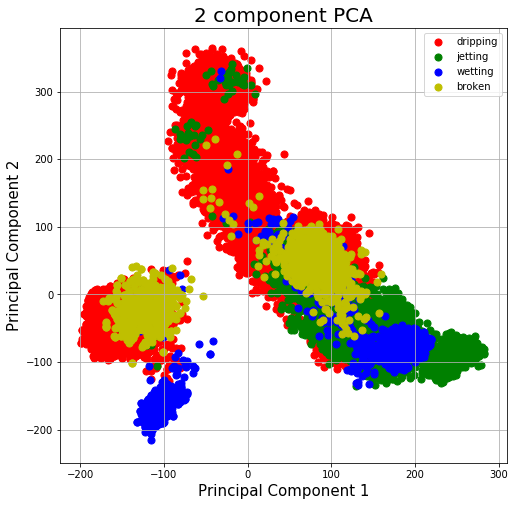

In [34]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1,2,3]
states = ['dripping', 'jetting', 'wetting', 'broken']
colors = ['r', 'g', 'b', 'y']
for target, color, state in zip(targets,colors,states):
    ##indicesToKeep = finalDf['target'] == target
    ind = im_lb == target
    ax.scatter(principalComponents[ind,0],#finalDf.loc[indicesToKeep, 'principal component 1']
               principalComponents[ind,1],#, finalDf.loc[indicesToKeep, 'principal component 2']
               c = color,
               s = 50)
ax.legend(states)
ax.grid()

In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(im_dataf)

In [49]:
%matplotlib ipympl
#%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_zlabel('PC 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)
targets = [0,1,2,3]
states = ['dripping', 'jetting', 'wetting', 'broken']
colors = ['r', 'g', 'b', 'y']
for target, color, state in zip(targets,colors,states):
    ##indicesToKeep = finalDf['target'] == target
    ind = im_lb == target
    ax.scatter(principalComponents[ind,0],#finalDf.loc[indicesToKeep, 'principal component 1']
               principalComponents[ind,1],#, finalDf.loc[indicesToKeep, 'principal component 2']
               principalComponents[ind,2],
               c = color,
               s = 50)
ax.legend(states)
ax.grid()

FigureCanvasNbAgg()

# PCA 3 components 3 Views 

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(im_dataf)

In [56]:
fig = plt.figure(figsize = (18,6))
for i in range(3):
    ax = fig.add_subplot(1,3,i+1) 
    #ax.set_xlabel('Principal Component 1', fontsize = 15)
    #ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_xlabel('Principal Component ', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    
    ax.set_title('3 component PCA', fontsize = 20)
    targets = [0,1,2,3]
    states = ['dripping', 'jetting', 'wetting', 'broken']
    colors = ['r', 'g', 'b', 'y']
    for target, color, state in zip(targets,colors,states):
        ##indicesToKeep = finalDf['target'] == target
        ind = im_lb == target
        ax.scatter(principalComponents[ind,i%3],#finalDf.loc[indicesToKeep, 'principal component 1']
                   principalComponents[ind,(i+1)%3],#, finalDf.loc[indicesToKeep, 'principal component 2']
                   c = color,
                   s = 50)
    ax.legend(states)
    ax.grid()

FigureCanvasNbAgg()

# To test, different preprocessing/ rotation blur/ normalization

# To test, which feature each cluster stands for

# To test, TDA 